# Classify and localize Thoracic diseases using DL!
Highlights:
1. Transfer learning using Resnet50

Plan
1. Load Data
    - Img and CSV data loaders
    - Data split
    - 
2. Preprocess 
    - Possibly augmentation
3. Run model
4. Display results
5. Localization enhancements

In [2]:
import torch
from skimage import io
import seaborn as sns

import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from PIL import Image
import cv2
import time
import numpy as np
import torchvision.models as models
from torch.optim import lr_scheduler
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms,utils
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable
import os
import pandas as pd
import glob
from skimage import io
import matplotlib.pyplot as plt
import os 

%matplotlib inline
use_gpu = torch.cuda.is_available()


In [15]:
# Config
DATA_DIR = 'data'
TRAIN_DIR = 'train_3_channel'
TEST_DIR = 'test'
VAL_DIR = 'val_3_channel'
TRAIN_DS_LOC = os.path.join(DATA_DIR, TRAIN_DIR)
TEST_DS_LOC = os.path.join(DATA_DIR, TEST_DIR)
VAL_DS_LOC = os.path.join(DATA_DIR, VAL_DIR)
IMG_PATTERN = '*.png'
IMG_PROPERTIES_FILE = 'Data_Entry_2017.csv'
LABEL_SEP = '|'
Height=512
Width=512



In [9]:
# Retrieve and process labels
l2i = {'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'No Finding': 10,
 'Nodule': 11,
 'Pleural_Thickening': 12,
 'Pneumonia': 13,
 'Pneumothorax': 14}

properties = pd.read_csv(IMG_PROPERTIES_FILE, skiprows=1, header=None, low_memory=False, na_filter=False).values
labels = {prop[0] : [ l2i[label] for label in  prop[1].split(LABEL_SEP)] for prop in properties}

num_classes=len(l2i)


In [10]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
         # transforms.ToPILImage(),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    
    ]),
    'val': transforms.Compose([
        # transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),

    ]),
}


In [3]:
#import image data set description
df = pd.read_csv('Data_Entry_2017.csv')
df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
df = df[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

for pathology in pathology_list :
    df[pathology] = df['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

#remove Y after age
df['Age']=df['Patient Age'].apply(lambda x: x[:-1]).astype(int)

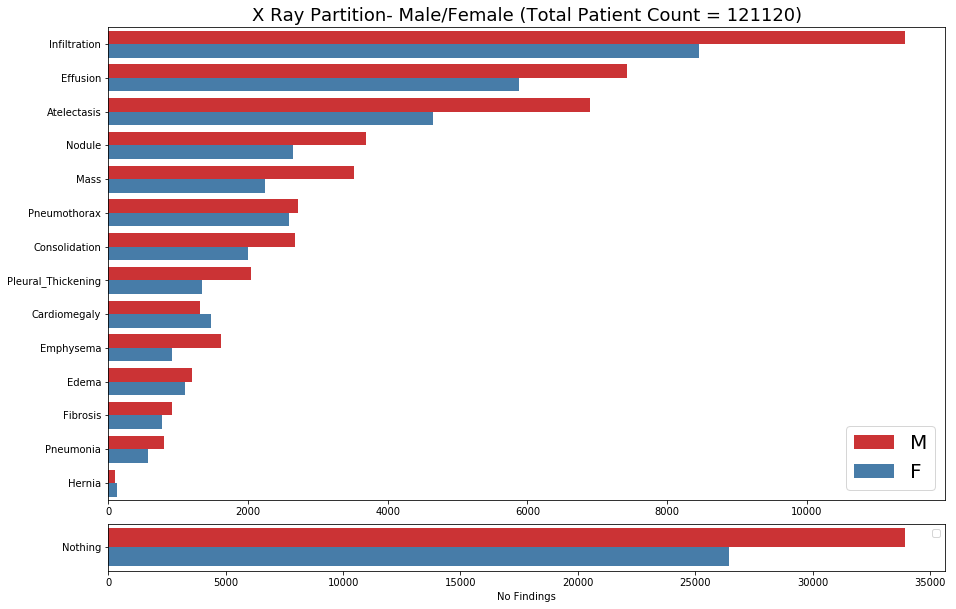

In [22]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(df,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, palette="Set1", \
    ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray Partition- Male/Female (Total Patient Count = 121120)',fontsize=18);

df['Nothing']=df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(df,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2,palette="Set1")
ax2.set( ylabel="",xlabel="No Findings")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

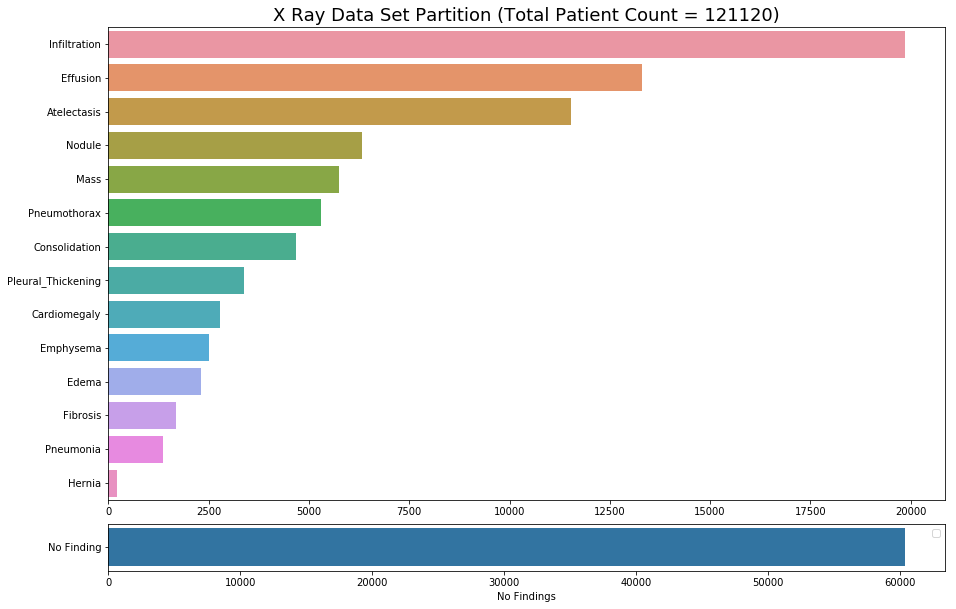

In [32]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(df,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',data=data1,  \
    ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray Data Set Partition (Total Patient Count = 121120)',fontsize=18);

df['No Finding']=df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(df,
             id_vars=['Patient Gender'],
             value_vars = list(['No Finding']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="No Findings")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

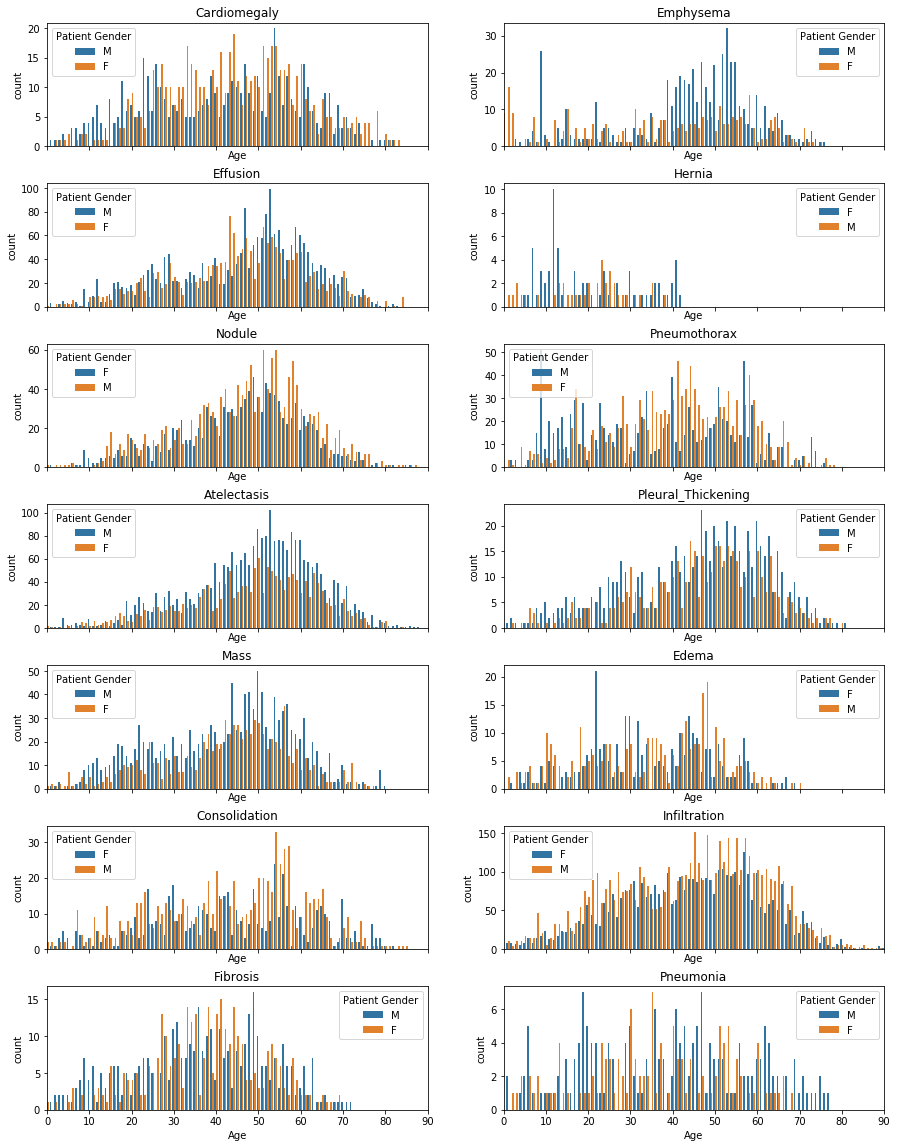

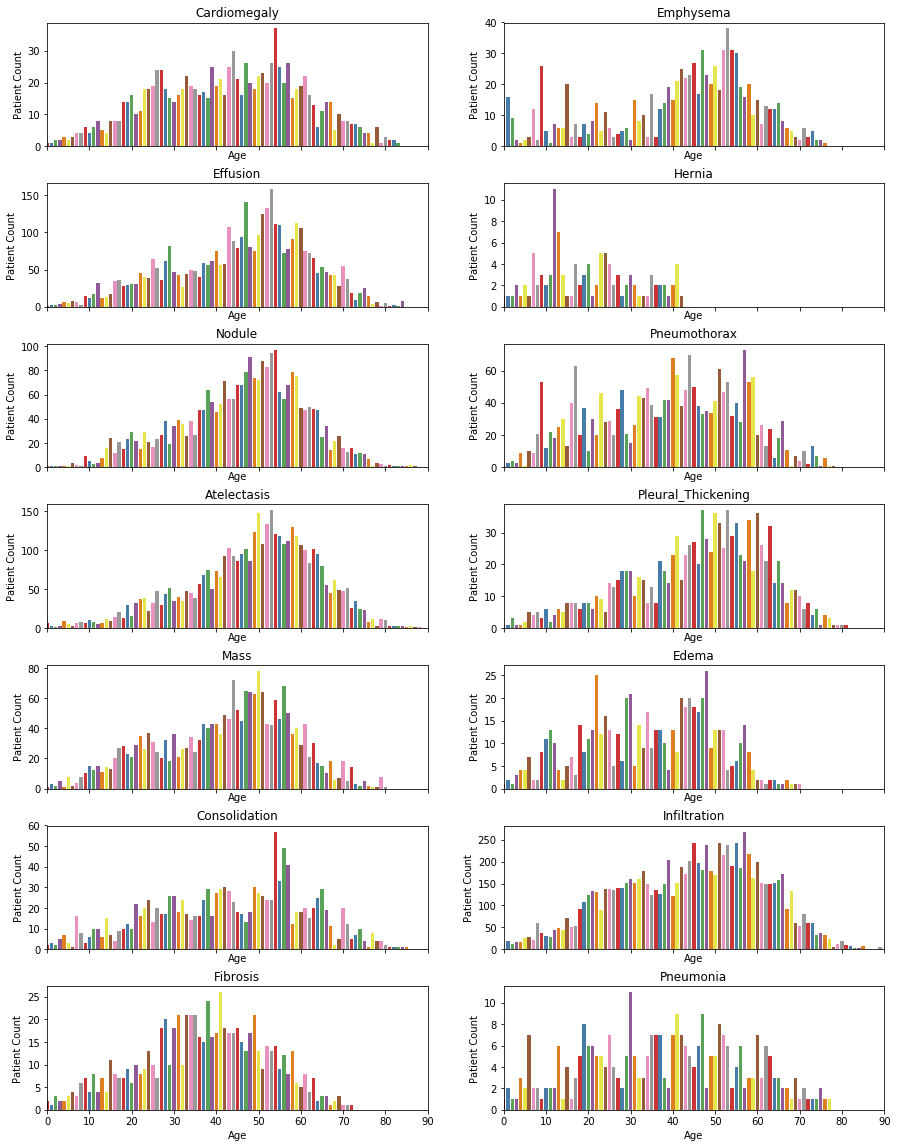

In [60]:
f, axarr1 = plt.subplots(7, 2, sharex=True,figsize=(15, 20))
ax2 = plt.subplot(sharex=True,figsize=(15, 20))
i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    g=sns.countplot(x='Age',data=df[df['Finding Labels']==pathology], ax=axarr1[i, j],palette="Set1")
    axarr1[i, j].set_title(pathology)
    g.set(xlabel='Age', ylabel='Patient Count')
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

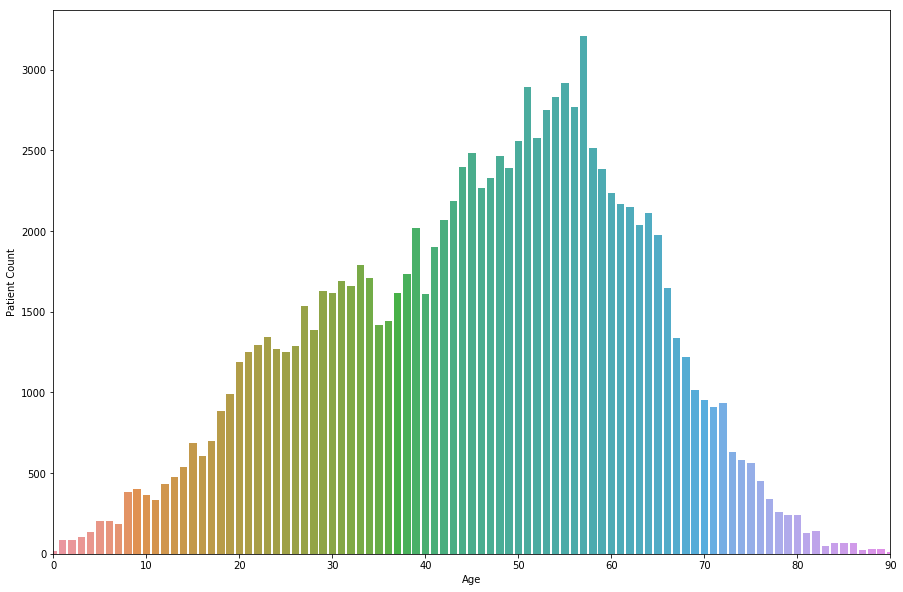

In [58]:
f, axarr = plt.subplots(1, 1, sharex=True,figsize=(15, 10))
g=sns.countplot(x='Age',data=df)
g.set(xlabel='Age', ylabel='Patient Count')
g.set_xlim(0,90)
g.set_xticks(x)
g.set_xticklabels(x)
f.subplots_adjust(hspace=0.3)

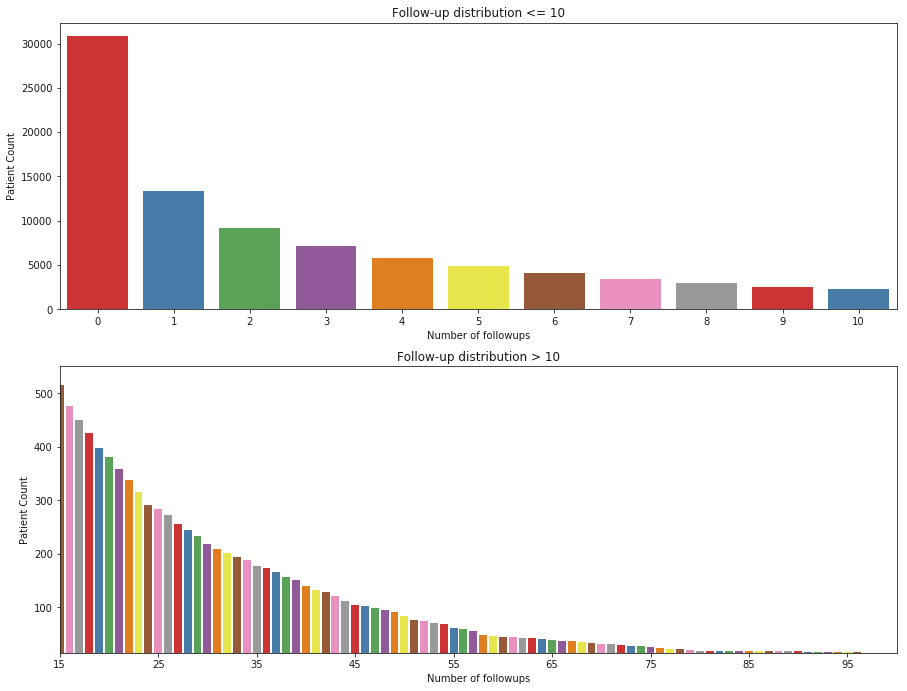

In [85]:
f, (ax1,ax2) = plt.subplots( 2, figsize=(15, 10))

data = df[df['Follow-up #']<=10]
g = sns.countplot(x='Follow-up #',data=data,palette="Set1",ax=ax1);
g.set(xlabel='Number of followups', ylabel='Patient Count')

ax1.set_title('Follow-up distribution <= 10');
data = df[df['Follow-up #']>10]
g = sns.countplot(x='Follow-up #',data=data,palette="Set1",ax=ax2);
ax2.set_title('Follow-up distribution > 10');

x=np.arange(15,100,10)
g.set(xlabel='Number of followups', ylabel='Patient Count')
g.set_ylim(15,550)
g.set_xlim(15,100)
g.set_xticks(x)
g.set_xticklabels(x)

f.subplots_adjust(top=1)

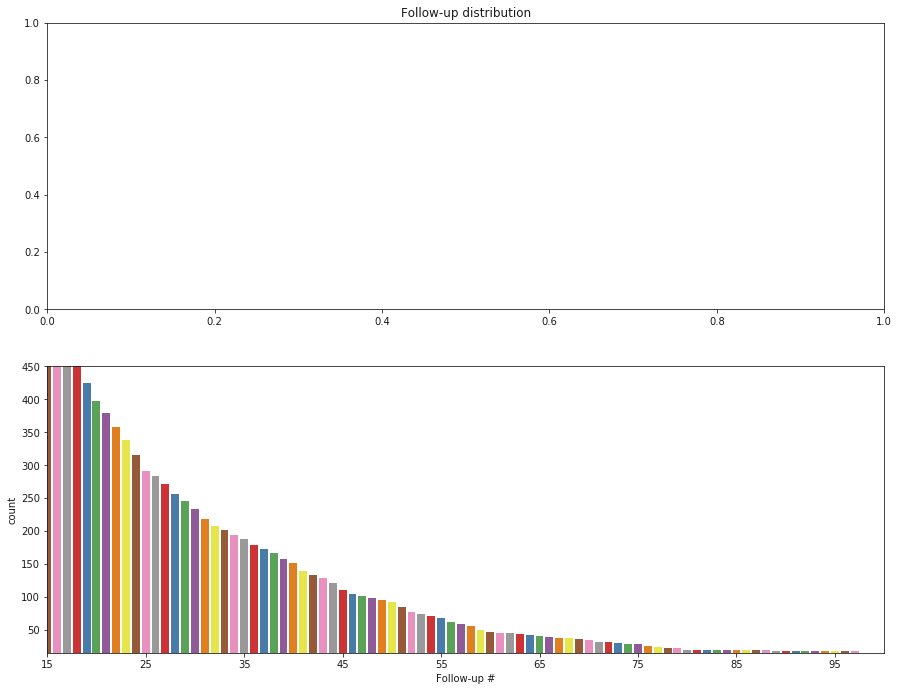

In [77]:
f, (ax1,ax2) = plt.subplots( 2, figsize=(15, 10))

data = df[df['Follow-up #']<10]
#g = sns.countplot(x='Follow-up #',data=data,palette="Set2",ax=ax1);

ax1.set_title('Follow-up distribution');
data = df[df['Follow-up #']>=10]
g = sns.countplot(x='Follow-up #',data=data,palette="Set1",ax=ax2);
x=np.arange(15,100,10)
g.set_ylim(15,450)
g.set_xlim(15,100)
g.set_xticks(x)
g.set_xticklabels(x)
f.subplots_adjust(top=1)

In [72]:
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values


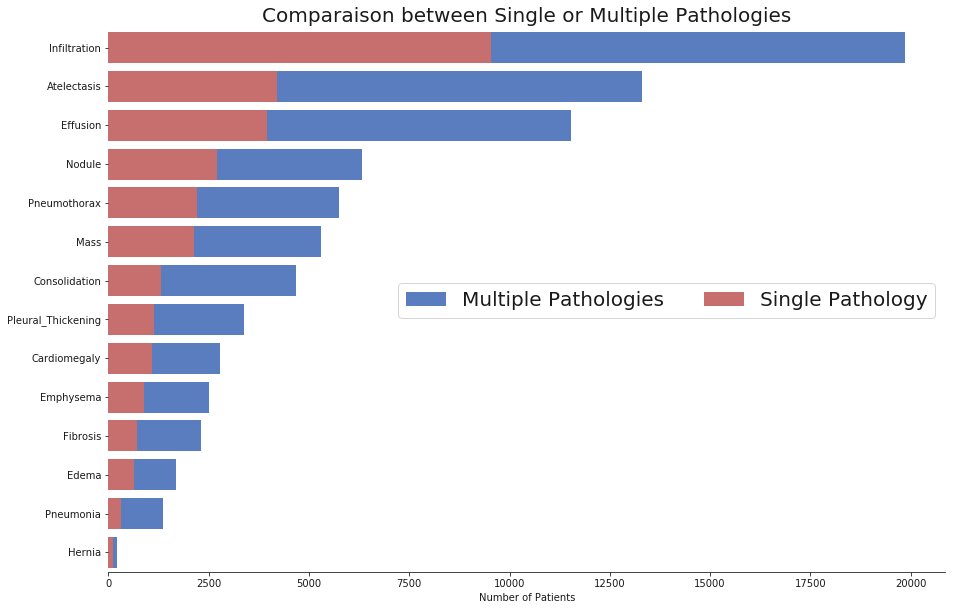

In [102]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="r",label="Single Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of Patients")
ax.set_title("Comparaison between Single or Multiple Pathologies",fontsize=20)      
sns.despine(left=True)

In [20]:
def label_standard_array(labels):
    standard_class=np.zeros(shape=num_classes)
    for i in labels:
       standard_class[i]=1
    return standard_class
    

torch.Size([3, 256, 256])


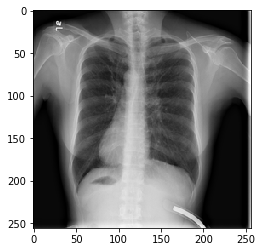

In [21]:
#def split TODO:training and test validations
class XrayFolderDS(Dataset):
    def __init__(self, root, transform = None):
        self.data = glob.glob(os.path.join(root, IMG_PATTERN))
        self.transform = transform
        # transforms.ToPILImage(),
        self.to_tensor = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        entry = self.data[index]
        name = os.path.split(entry)[-1]
        # img = cv2.imread(entry)
        img = Image.open(entry,)
        img.load()
        img = self.transform(img)
        labels_name=label_standard_array(labels[name])
        return img,labels_name
        
test_d = XrayFolderDS(TRAIN_DS_LOC,data_transforms['train'])[1][0]
# convert to np and remove extra dim
numpy_d = test_d.numpy()[0] 
print(test_d.size())
plt.imshow(numpy_d, cmap='gray') # Remove gray for green normalized image :D
plt.show()

In [22]:
#Test the loading code
class XrayFolderDS2(Dataset):
    def __init__(self, root, transform = None):
        self.data = glob.glob(os.path.join(root, IMG_PATTERN))
        self.transform = transform
        # transforms.ToPILImage(),
        self.to_tensor = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        entry = self.data[index]
        name = os.path.split(entry)[-1]
        # img = cv2.imread(entry)
        img = Image.open(entry,)
        img.load()
        img = self.transform(img)
        labels_name=label_standard_array(labels[name])
        return img,labels_name

import line_profiler

def ftst():
    
    ds = DataLoader(tds, batch_size=25, shuffle=True)
    s = 0
    t = time.time()
    for e, i in enumerate(ds):
        s+=len(i)
        if e == 100:
            print(i[0].size())
            break
    print('took {:.4f} seconds '.format(time.time() - t,))

tds = XrayFolderDS2(TRAIN_DS_LOC,data_transforms['train'])

lpx = line_profiler.LineProfiler(tds.__getitem__)
#print(dir(lpx))
lpx(ftst)()
lpx.print_stats()
    

torch.Size([25, 3, 256, 256])
took 17.6770 seconds 
Timer unit: 1e-06 s

Total time: 16.5926 s
File: <ipython-input-22-8dbe2b37ca7f>
Function: __getitem__ at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                               def __getitem__(self, index):
    13      2525         4872      1.9      0.0          entry = self.data[index]
    14      2525        27685     11.0      0.2          name = os.path.split(entry)[-1]
    15                                                   # img = cv2.imread(entry)
    16      2525      4591853   1818.6     27.7          img = Image.open(entry,)
    17      2525      7986611   3163.0     48.1          img.load()
    18      2525      3927444   1555.4     23.7          img = self.transform(img)
    19      2525        51944     20.6      0.3          labels_name=label_standard_array(labels[name])
    20      2525         2147      0.9      0.0          return img,labels_name

Total time: 17.

In [23]:
# Hyperparameters
BATCH_SIZE = 25


In [24]:
# Prepare Data
# print( [d for d in os.listdir(TRAIN_DS_LOC) ] )

#print(os.getcwd()+'\\data\\train\\', torchvision.datasets.folder.find_classes('data/train'))
train_dataset = XrayFolderDS(TRAIN_DS_LOC,data_transforms['train'])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = XrayFolderDS(VAL_DS_LOC,data_transforms['val'])
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

dataloaders={'train':train_dataloader,'val':val_dataloader}
dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}

# test_dataset = XrayFolderDS(TRAIN_DS_LOC,data_transforms['test'])
# test_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# TODO: Implement k fold cross validation


In [25]:
# def show_xray_batch(sample_batched):
#     """Show image with landmarks for a batch of samples."""
#     xrays_batch,labels_batch = sample_batched
#     print('labels_batch batch size',labels_batch.shape)
#     print(len(labels_batch))
#     grid_1 = utils.make_grid(xrays_batch)
#     plt.imshow(grid_1.numpy().transpose(( 1,2, 0)))


# for i_batch, sample_batched in enumerate(train_dataloader):
#     print ('Batch Number', i_batch)
#     # observe 4th batch and stop.
#     if i_batch == 5:
#         plt.figure()
#         show_xray_batch(sample_batched)
#         plt.axis('off')
#         plt.ioff()
#         plt.show()
#         break

In [26]:
xray_model = models.resnet50(pretrained=True)


In [27]:
num_ftrs = xray_model.fc.in_features
# changing the final_layer for our images 
xray_model.fc = nn.Linear(num_ftrs,num_classes)
print(xray_model.fc)
print(xray_model)

Linear (2048 -> 15)
ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )

In [84]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    i = 0 
    start_time = time.time()
    TP = torch.zeros( num_classes).double()
    FP = torch.zeros( num_classes).double()
    TN = torch.zeros( num_classes).double()
    FN = torch.zeros( num_classes).double()
    zero_tensor =  torch.zeros(BATCH_SIZE, num_classes)
    one_tensor = torch.ones(BATCH_SIZE, num_classes)


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)


        # Each epoch has a training and validation phase
        for phase in ['val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            count =0
            
            print('Total Batches: ', len(dataloaders[phase]))

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                # wrap them in Variable
                
                if phase == 'train':
                    inputs, labels = Variable(inputs), Variable(labels)
                else:
                    inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
                
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
               

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = torch.sigmoid(model(inputs))
                preds = torch.sign(torch.sign(outputs.data-0.5)+1)
                # print(outputs.size())
                
                
                loss = criterion(outputs.double(), labels)
                
                    
        

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                part_corr = torch.sum((preds == labels.data.float()),1).double()
                # Average fraction of correct labels
                corr_avg =  torch.mean(part_corr)/float(num_classes)
                #corrects = torch.sum(part_corr == num_classes)
                running_corrects += torch.sum(part_corr)
                
                #tp
                overall_corr = torch.sum((preds == labels.data.float()),0).double()
                overall_incorr = torch.sum((preds != labels.data.float()),0).double()
                
                curr_TN = torch.sum(( (preds ==zero_tensor) + (zero_tensor == labels.data.float()))==2,0).double()
                curr_TP = overall_corr - curr_TN
                
                curr_FP = torch.sum(( (preds==one_tensor) + (zero_tensor == labels.data.float()))==2,0).double()
                curr_FN =  overall_incorr  - curr_FP
                
                count += BATCH_SIZE
                
                TP+=curr_TP
                TN+=curr_TN
                FP+=curr_FP
                FN+=curr_FN
                
#                 print(labels)
#                 print(preds)
                
               
 
                # f1 
                if i%50==10:
                    print("i is",i)
                    print("time passed. {:.2f} ".format(time.time()-start_time))

                    precision =  torch.sum(TP)/torch.sum(TP+FP)
                    
                    
                    print("recall , precision ",precision,recall)
                    print('Tp',TP/count)
                    print('Tn',TN/count)
                    print('FP',FP/count)
                    print('FN', FN/count)
                    Tp_each=TP/count
                    Tn_each=TN/count
                    Fp_each = FP/count
                    Fn_each = FN/count
                    
                    print("TP,TN,FP,FN", (torch.sum(TP))/BATCH_SIZE,(torch.sum(TN))/BATCH_SIZE,(torch.sum(FP))/BATCH_SIZE,(torch.sum(FN))/BATCH_SIZE)

                    class_curr_ac = (TP+TN)/count
                    print("curr class ac",class_curr_ac)
                    
                    if (precision+recall)==0:
                        print("Zero True Positive")
                    else:
                        f=2*precision*recall/(precision+recall)
                        print(' F score {:.4f} '.format(f))
                    
                    print(' Loss: {:.4f} '.format(loss.data[0]))

                    
                i=i+1


            epoch_loss = running_loss / float(dataset_sizes[phase])
            epoch_acc = running_corrects / (float(dataset_sizes[phase]) * float(num_classes))


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc ))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            
            if phase == 'train':
                torch.save(model.state_dict(), open("projectx_%s_%f.model" % (epoch, epoch_loss), 'wb'))



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Optimizer and Loss

In [85]:
if use_gpu:
    xray_model = xray_model.cuda()
    print("GPU POWER FTW")

criterion = nn.MultiLabelSoftMarginLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(xray_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [86]:
state = torch.load("projectx_10_0.006655.model", map_location=lambda storage, loc: storage)
xray_model.load_state_dict(state)

In [87]:
model_ft = train_model(xray_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
('Total Batches: ', 466)
('i is', 10)
time passed. 61.98 


NameError: global name 'recall' is not defined